In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

### (a) Data Preprocessing

The first step before building our model is to preprocess the data. This involves removing the punctuation, removing the stop words and converting the text to lowercase. We will do this with the help of NLTK library.

We will also convert the stars into three levels, Positive, Negative and Neutral.

In [3]:
# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arunimsamudra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load the Yelp review dataset
data = pd.read_csv('yelp_review_train.csv')

In [5]:
data.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


In [6]:
# Function to preprocess text
def preprocess_text(text):
    # Remove punctuation and convert text to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

In [7]:
# Apply text preprocessing to the 'text' column
data['processed_text'] = data['text'].apply(preprocess_text)

In [8]:
# Remove stopwords using NLTK
stop_words = set(stopwords.words('english'))
data['processed_text'] = data['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [9]:
# Convert stars into three levels: Positive (> 3), Negative (<= 2), Neutral (= 3)
def categorize_stars(stars):
    if stars > 3:
        return 'Positive'
    elif stars <= 2:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment'] = data['stars'].apply(categorize_stars)

# Display the processed data
print(data[['processed_text', 'sentiment']].head())

                                      processed_text sentiment
0  went lunch found burger meh obvious focus burg...  Negative
1  needed new tires wifes car special order next ...  Positive
2  jim woltman works goleta honda 5 stars knowled...  Positive
3  times get shrimp theyve got nice selection dif...  Positive
4  one fantastic place eat whether hungry need go...  Positive


### (b) Input data preparation

After preprocessing our text data, we need to convert our data into numbers, specifically tensors, since we will be using PyTorch. Theses tensors will be fed as input to out model for prediction.

In [10]:
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

In [11]:
# Only for Mac M2 Chip Devices
torch.backends.mps.is_available()
device = torch.device("mps")

First, we will generate tokens from the text which will be used to build our vocabulary.

In [12]:
preprocessed_text = data['processed_text'].tolist()
sentiments = data['sentiment'].tolist()

# Build vocabulary from the preprocessed reviews
def yield_tokens(data):
    for review in data:
        yield review.split()

vocab = build_vocab_from_iterator(yield_tokens(preprocessed_text), specials=['<pad>', '<unk>'])

We will then numericalize tokens based on the vocabulary, pad reviews to a fixed length, and map sentiment labels to numerical values

In [13]:
# Convert words to integers based on the vocabulary
def numericalize_tokens(data, vocab):
    numericalized = []
    for review in data:
        tokens = [vocab[token] if token in vocab else vocab['<unk>'] for token in review.split()]
        numericalized.append(tokens)
    return numericalized

numericalized_reviews = numericalize_tokens(preprocessed_text, vocab)

In [14]:
# Pad the reviews to a fixed length, here it is 100
max_length = 100

padded_reviews = [torch.tensor(review[:max_length] + [vocab['<pad>']] * (max_length - len(review))) for review in numericalized_reviews]

Finally, we just need to convert them into PyTorch tensors.

In [15]:
# Convert sentiment labels to numerical values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
numerical_sentiments = [sentiment_mapping[sentiment] for sentiment in sentiments]

# Create tensors for reviews and sentiments
tensor_reviews = torch.stack(padded_reviews)
tensor_sentiments = torch.tensor(numerical_sentiments)

# Display shapes of tensor_reviews and tensor_sentiments
print(f"Shape of tensor_reviews: {tensor_reviews.shape}")
print(f"Shape of tensor_sentiments: {tensor_sentiments.shape}")

Shape of tensor_reviews: torch.Size([174757, 100])
Shape of tensor_sentiments: torch.Size([174757])


### (c) Transformer Implementation

In this section, we will implement a trasformer based only on the encoder. An encoder in a transformer consists of a Positional Embedding block, a Multi Head Attention block and a Feed Forward Network

In [57]:
# Import the required libraries
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import math

#### Positional Embedding

Positional Embeddings are added to the input embeddings to encode information about the position of each token in the sequence. This allows the model to differentiate between tokens solely based on their position.

In [58]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEmbedding, self).__init__()

        # Tensor which will be populated with positional encodings
        pe = torch.zeros(max_seq_length, d_model)
        # Tensor containing the position indices for each position in the sequence.
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

We have created a class PositionEmbedding defined as a subclass of PyTorch's nn.Module.

We have the following parameters in the constructor for this class-
- `d_model`: the dimensionality of the model
- `max_seq_length`: maximum length of the input sequence

Inside the constructor. we initialize a tensor `pe` of shape `(max_seq_length, d_model)` with zeros. This tensor will be populated with positional embeddings. We then create a tensor `position` containing position indices for each position in the sequence, and `div_term` for exponential scaling.

We populate the `pe` tensor with positional embeddings after calculating the sine and cosine values for each position and dimension.

In the forward method of this class (forward pass), we add the positional embeddings (`self.pe`) to the input tensor `x`. The positional embeddings are sliced to match the length of the input sequence.

#### MultiHead Attention

The Multi-Head Attention block is a crucial component of the Transformer architecture, introduced to capture different aspects of the relationships between words in a sequence. The attention mechanism allows the model to focus on different parts of the input sequence when processing each word. Multi-Head Attention enhances this mechanism by using multiple attention heads in parallel, each learning different aspects of the relationships.

In [59]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])

    def attention(self, query, key, value, mask=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            mask = mask.permute(1, 0, 2)  # Transpose the mask
            mask = mask.unsqueeze(1).expand(-1, query.size(1), -1, -1)  # Expand the mask's dimensions
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, value)
        return output

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Apply linear transformation for each head
        query, key, value = [l(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]

        # Perform attention
        x = self.attention(query, key, value, mask=mask)

        # Concatenate heads and apply final linear transformation
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linears[-1](x)

We have created code a PyTorch module for a Multi-Head Attention block. It has the following parameters:

- `d_model`: dimensionality of model
- `num_heads`: number of attention heads

We also check if `d_model` is divisible by `num_heads`. We then create a list of four linear layers (`linears`) using `nn.ModuleList`, each with input and output size `d_model`.

The **Attention Method** takes `query`, `key`, and `value` as input tensors, representing the linear projections of the input sequences.
We then compute the attention scores using scaled dot-product attention, calculate the attention weights using the softmax function and finally compute the weighted sum of values using the attention weights.

The **Forward Method:** also takes `query`, `key`, and `value` as input tensors. We apply linear transformations to each input using the linear layers in `self.linears` and reshape them to have dimensions `(batch_size, num_heads, sequence_length, d_k)`. We then calculate the `attention` method to compute attention-weighted values. Finally, we concatenate the output from the attention heads and apply a final linear transformation to it.

#### Position Wise Feed Forward Network

The Position Wise Feedforward Network is a component applied independently to each position in the sequence. It consists of two linear transformations with a non-linear activation function in between. The purpose of the Position-wise Feedforward Network is to introduce non-linearity and enable the model to capture complex relationships between different positions in the sequence.

In [60]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

#### Creating an Encoder Layer

The subsequent stage involves the construction of the Encoder Layer, which incorporates a multi-head self-attention mechanism, followed by a position-wise feed-forward neural network, layer normalization, and appropriately applied dropout.

In [61]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

Within the EncoderLayer class, a singular layer of the transformer's encoder is defined. The combination of these elements enables the encoder to discern intricate relationships within the input data and convert them into a meaningful representation for subsequent tasks. Typically, several such encoder layers are stacked to constitute the entire encoder section of a transformer model.

#### Transformer

Our last step is to combine all the blocks to build our Transformer model.

In [62]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_encoder_layers=3, dim_feedforward=512, max_seq_len=100, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEmbedding(d_model, max_seq_length=max_seq_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_encoder_layers)])

        self.fc = nn.Linear(d_model, 3)  # Output for three classes: Positive, Neutral, Negative

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        # Mask for padded tokens
        mask = (x != 0).transpose(0, 1)  # Transpose the mask

        for layer in self.encoder_layers:
            x = layer(x, mask=mask)  # Pass the mask to each Transformer layer

        x = x.mean(dim=1)  # Pooling: average across tokens
        x = self.fc(x)
        return x

The Transformer class has the following parameters:
- `vocab_size`: Size of the vocabulary.
- `d_model`: Dimensionality of the model (default is 128).
- `nhead`: Number of attention heads in the multi-head attention layer (default is 4).
- `num_encoder_layers`: Number of encoder layers in the transformer (default is 3).
- `dim_feedforward`: Dimensionality of the feedforward layer (default is 512).
- `max_seq_len`: Maximum sequence length for positional encoding (default is 100).
- `dropout`: Dropout probability (default is 0.1).

Our model embeds input sequences using an embedding layer, applies positional encoding using a custom `PositionalEmbedding` class, utilizes multiple layers of a custom `EncoderLayer` in the encoder section and lastly employs a linear layer for the final output with three classes: Positive, Neutral, and Negative.

### (d) Model Training

Finally, it's time for training.

In [78]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [79]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tensor_reviews, tensor_sentiments, test_size=0.1, random_state=42)

In [80]:
# Create DataLoader for training and validation sets
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [91]:
# Hyperparameters for the model
d_model = 128
num_heads = 4
num_layers = 3
d_ff = 256
max_seq_length = 100
dropout = 0.1
# (The above hyperparameters were selected after some tuning over different values, 
#  have not included it here since it takes a lot of time to train the Transformer)

In [92]:
# Define the model, loss function, optimizer
model = Transformer(vocab_size=len(vocab), d_model=d_model, nhead=num_heads, num_encoder_layers=num_layers, dim_feedforward=d_ff, max_seq_len=max_seq_length, dropout=dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [93]:
# Set seed for reproducibility
torch.manual_seed(42)
torch.mps.manual_seed(42)

We will perform training over 100 epochs

In [85]:
# Training loop
num_epochs = 100
best_accuracy = 0.0
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            _, predicted_val = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/100] - Loss: 0.8164 - Accuracy: 67.09%
Validation Accuracy: 66.69%
Epoch [2/100] - Loss: 0.8144 - Accuracy: 67.09%
Validation Accuracy: 66.69%
Epoch [3/100] - Loss: 0.8127 - Accuracy: 67.09%
Validation Accuracy: 66.69%
Epoch [4/100] - Loss: 0.8107 - Accuracy: 67.09%
Validation Accuracy: 66.69%
Epoch [5/100] - Loss: 0.8085 - Accuracy: 67.10%
Validation Accuracy: 66.72%
Epoch [6/100] - Loss: 0.8061 - Accuracy: 67.12%
Validation Accuracy: 66.77%
Epoch [7/100] - Loss: 0.8031 - Accuracy: 67.16%
Validation Accuracy: 66.85%
Epoch [8/100] - Loss: 0.7994 - Accuracy: 67.22%
Validation Accuracy: 67.03%
Epoch [9/100] - Loss: 0.7944 - Accuracy: 67.38%
Validation Accuracy: 67.06%
Epoch [10/100] - Loss: 0.7868 - Accuracy: 67.57%
Validation Accuracy: 67.15%
Epoch [11/100] - Loss: 0.7723 - Accuracy: 67.92%
Validation Accuracy: 67.52%
Epoch [12/100] - Loss: 0.7465 - Accuracy: 68.80%
Validation Accuracy: 69.13%
Epoch [13/100] - Loss: 0.7243 - Accuracy: 70.32%
Validation Accuracy: 70.26%
Epoch [1

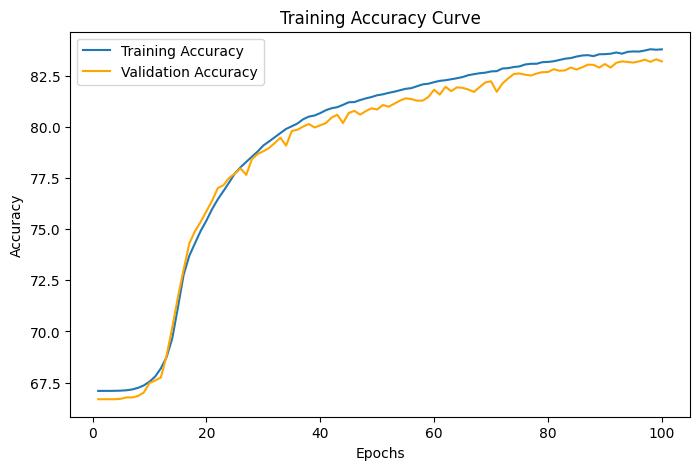

In [52]:
# Plotting the training curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

In [86]:
print(f"Best Validation accuracy {best_accuracy}%")

Best Validation accuracy 82.90798809796291%


Findings:

- During the initial 15 epochs, there was a gradual increase in accuracy, indicating a slow learning phase.
- Subsequently, there was a rapid surge in accuracy, jumping from approximately 68% to 82% by the 40th epoch.
- Beyond the 40th epoch, the accuracy curve exhibited a plateau, suggesting a stabilization or saturation in model learning.

### (e) Result Analysis



After we have finished training, it's time to test our model on the test dataset.

First, we will load our best model.

In [95]:
best_model = Transformer(vocab_size=len(vocab), d_model=d_model, nhead=num_heads, num_encoder_layers=num_layers, dim_feedforward=d_ff, max_seq_len=max_seq_length, dropout=dropout)
best_model.load_state_dict(torch.load('best_model.pth'))  # Load the saved weights
best_model.eval()  # Set the model to evaluation mode

Transformer(
  (embedding): Embedding(148266, 128)
  (positional_encoding): PositionalEmbedding()
  (encoder_layers): ModuleList(
    (0-2): 3 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

The test dataset will also be processed in the same way as training data

In [96]:
test = pd.read_csv('yelp_review_test.csv')

test['processed_text'] = test['text'].apply(preprocess_text)

# Remove stopwords using NLTK
stop_words = set(stopwords.words('english'))
test['processed_text'] = test['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test['sentiment'] = test['stars'].apply(categorize_stars)

test_preprocessed_text = test['processed_text'].tolist()
test_vocab = build_vocab_from_iterator(yield_tokens(test_preprocessed_text), specials=['<pad>', '<unk>'])

test_numericalized_reviews = numericalize_tokens(test_preprocessed_text, test_vocab)
test_sentiments = test['sentiment'].tolist()

# Pad the reviews to a mean length
max_length = 100
test_padded_reviews = [torch.tensor(review[:max_length] + [vocab['<pad>']] * (max_length - len(review))) for review in test_numericalized_reviews]

test_numerical_sentiments = [sentiment_mapping[sentiment] for sentiment in test_sentiments]

test_tensor_reviews = torch.stack(test_padded_reviews)
test_tensor_sentiments = torch.tensor(test_numerical_sentiments)

In [1]:
# Assuming you have prepared the test dataset similarly to the training data
test_dataset = TensorDataset(test_tensor_reviews, test_tensor_sentiments)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Accuracy on Test Set: {test_accuracy:.4f}")

Accuracy on Test Set: 0.8135


The accuracy of the test set was 81%

The current model performance on the test dataset indicates a moderate level of effectiveness. To enhance our model's performance, we can consider fine-tuning certain hyperparameters. For instance, increasing the hidden dimension or adding more attention layers could potentially facilitate better learning of the underlying data patterns. <br>
Also, there is a gap between the training and test accuracies. This could involve incorporating regularization techniques. Adjusting the dropout value or introducing additional batch normalization layers may prove beneficial in achieving a more balanced and generalized model performance. <br>
By strategically tweaking these hyperparameters and regularization strategies, we aim to optimize our model's capability to understand and generalize from the data.